# Implementing paper "A Deep Learning Approach for Network Intrusion Detection Using a Small Features Vector"

In [1]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os

folder_path = '/content/drive/MyDrive/CS240/UNSW-NB15'
files = os.listdir(folder_path)

train_file = 'UNSW_NB15_training-set.csv'
test_file = 'UNSW_NB15_testing-set.csv'
train_path = os.path.join(folder_path, train_file)
test_path = os.path.join(folder_path, test_file)
print("Visualizing data from:", train_path)
try:
    data = pd.read_csv(train_path, encoding='latin1')
    display(data.head())
    display(data.shape)
except Exception as e:
    print("Error reading file:", e)
print(data.shape)

Visualizing data from: /content/drive/MyDrive/CS240/UNSW-NB15/UNSW_NB15_training-set.csv


,ï»¿id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


(82332, 45)

(82332, 45)


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from matplotlib import pyplot as plt
from keras.layers import Embedding,Dense,LSTM,Dropout,Flatten,BatchNormalization,Conv1D,GlobalMaxPooling1D,MaxPooling1D
from keras.optimizers import  SGD
import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing import sequence
#from hyperas.distributions import uniform
from keras import regularizers
import string

import os

In [7]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
print("Length of training set: ", len(df_train))
print("Length of testing set: ", len(df_test))

Length of training set:  82332
Length of testing set:  175341


In [8]:
df = pd.concat([df_train, df_test])
# information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257673 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 257673 non-null  int64  
 1   dur                257673 non-null  float64
 2   proto              257673 non-null  object 
 3   service            257673 non-null  object 
 4   state              257673 non-null  object 
 5   spkts              257673 non-null  int64  
 6   dpkts              257673 non-null  int64  
 7   sbytes             257673 non-null  int64  
 8   dbytes             257673 non-null  int64  
 9   rate               257673 non-null  float64
 10  sttl               257673 non-null  int64  
 11  dttl               257673 non-null  int64  
 12  sload              257673 non-null  float64
 13  dload              257673 non-null  float64
 14  sloss              257673 non-null  int64  
 15  dloss              257673 non-null  int64  
 16  si

In [9]:
df.describe(include="all")

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
count,257673.000000,257673.000000,257673,257673,257673,257673.000000,257673.000000,2.576730e+05,2.576730e+05,2.576730e+05,...,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673,257673.000000
unique,NaN,NaN,133,13,11,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN
top,NaN,NaN,tcp,-,FIN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN
freq,NaN,NaN,123041,141321,117164,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93000,NaN
mean,72811.823858,1.246715,NaN,NaN,NaN,19.777144,18.514703,8.572952e+03,1.438729e+04,9.125391e+04,...,4.032677,8.322964,0.012819,0.012850,0.132005,6.800045,9.121049,0.014274,NaN,0.639077
std,48929.917641,5.974305,NaN,NaN,NaN,135.947152,111.985965,1.737739e+05,1.461993e+05,1.603446e+05,...,5.831515,11.120754,0.116091,0.116421,0.681854,8.396266,10.874752,0.118618,NaN,0.480269
min,1.000000,0.000000,NaN,NaN,NaN,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,NaN,0.000000
25%,32210.000000,0.000008,NaN,NaN,NaN,2.000000,0.000000,1.140000e+02,0.000000e+00,3.078928e+01,...,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,NaN,0.000000
50%,64419.000000,0.004285,NaN,NaN,NaN,4.000000,2.000000,5.280000e+02,1.780000e+02,2.955665e+03,...,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,NaN,1.000000
75%,110923.000000,0.685777,NaN,NaN,NaN,12.000000,10.000000,1.362000e+03,1.064000e+03,1.250000e+05,...,3.000000,8.000000,0.000000,0.000000,0.000000,8.000000,11.000000,0.000000,NaN,1.000000


In [10]:
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


<Axes: >

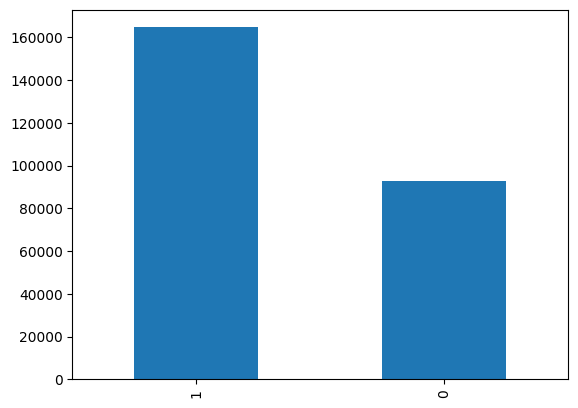

In [11]:
df['label'].value_counts().plot.bar()

In [12]:
df['label'].value_counts(normalize=True)

1    0.639077
0    0.360923
Name: label, dtype: float64

In [13]:
df = df.drop(columns=['id', 'attack_cat'])

In [14]:
df_cat = df.select_dtypes(exclude=[np.number])
print(df_cat.columns)
for feature in df_cat.columns:
    df[feature] = LabelEncoder().fit_transform(df[feature])

Index(['proto', 'service', 'state'], dtype='object')


In [15]:
df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0.000011,119,0,5,2,0,496,0,90909.0902,254,...,1,1,2,0,0,0,1,2,0,0
1,0.000008,119,0,5,2,0,1762,0,125000.0003,254,...,1,1,2,0,0,0,1,2,0,0
2,0.000005,119,0,5,2,0,1068,0,200000.0051,254,...,1,1,3,0,0,0,1,3,0,0
3,0.000006,119,0,5,2,0,900,0,166666.6608,254,...,2,1,3,0,0,0,2,3,0,0
4,0.000010,119,0,5,2,0,2126,0,100000.0025,254,...,2,1,3,0,0,0,2,3,0,0


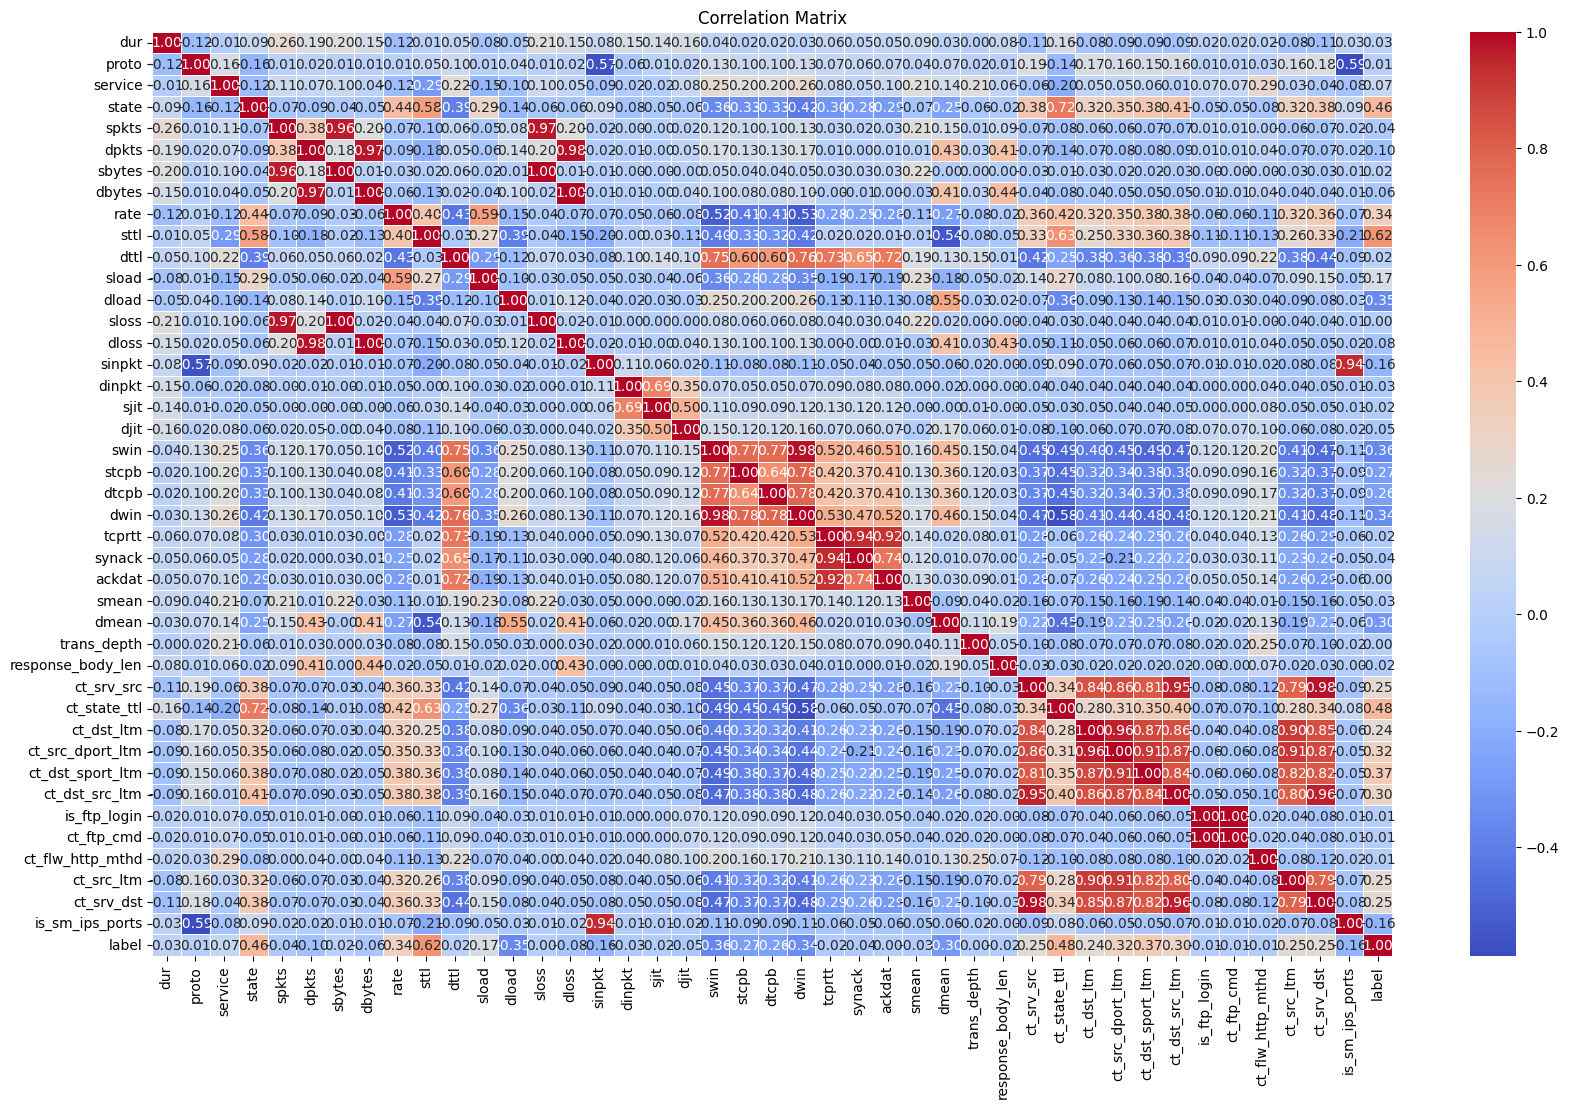

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming corr_matrix is your correlation matrix
plt.figure(figsize=(20, 12))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257673 entries, 0 to 175340
Data columns (total 43 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                257673 non-null  float64
 1   proto              257673 non-null  int64  
 2   service            257673 non-null  int64  
 3   state              257673 non-null  int64  
 4   spkts              257673 non-null  int64  
 5   dpkts              257673 non-null  int64  
 6   sbytes             257673 non-null  int64  
 7   dbytes             257673 non-null  int64  
 8   rate               257673 non-null  float64
 9   sttl               257673 non-null  int64  
 10  dttl               257673 non-null  int64  
 11  sload              257673 non-null  float64
 12  dload              257673 non-null  float64
 13  sloss              257673 non-null  int64  
 14  dloss              257673 non-null  int64  
 15  sinpkt             257673 non-null  float64
 16  di

In [18]:
#sample 10000 entries to make computation easier for fruitfly
sampled_df = df.sample(n=10000)

paperFeatures = [2,21,22,23,27,34,11,25,32,42]
paper_df = df.iloc[:,paperFeatures]

In [19]:
paper_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257673 entries, 0 to 175340
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   service           257673 non-null  int64  
 1   dtcpb             257673 non-null  int64  
 2   dwin              257673 non-null  int64  
 3   tcprtt            257673 non-null  float64
 4   dmean             257673 non-null  int64  
 5   ct_dst_sport_ltm  257673 non-null  int64  
 6   sload             257673 non-null  float64
 7   ackdat            257673 non-null  float64
 8   ct_dst_ltm        257673 non-null  int64  
 9   label             257673 non-null  int64  
dtypes: float64(3), int64(7)
memory usage: 21.6 MB


In [20]:
X = paper_df.drop(columns=['label'])
feature_list1 = list(X.columns)
X = np.array(X)
y = paper_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [21]:
y.shape

(257673,)

In [22]:
print("Training set:", len(X_train))
print("Testing set:", len(X_test))

Training set: 206138
Testing set: 51535


In [23]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch.optim.lr_scheduler as lr_scheduler

# Check if GPU is available
if torch.cuda.is_available():
  device = torch.device("cuda")
elif torch.backends.mps.is_available():
  device = torch.device("mps")
else:
  device = torch.device("cpu")

print("Using device: ", device)
# Define your neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.fc2 = nn.Linear(50, 30)
        self.fc3 = nn.Linear(30, 15)
        self.fc4 = nn.Linear(15, 5)
        self.fc5 = nn.Linear(5, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Example usage
# Define input dimension
input_dim = X_train.shape[1]
batch_size = 64
epochs = 50

# Move the model to GPU
model = NeuralNetwork(input_dim).to(device)

# Convert your data to PyTorch tensors and move to GPU
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train.values).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test.values).to(device)


# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters())
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Define your dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Train your model
total_batches = len(train_loader)
# Define early stopping parameters
early_stopping_rounds = 5
best_val_loss = float('inf')
best_epoch = 0
early_stopping_counter = 0

# Train your model
for epoch in range(epochs):
    running_loss = 0.0
    val_loss = 0.0
    with tqdm(total=total_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss / (i+1)})
            pbar.update(1)

        # Calculate validation loss
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            val_loss = criterion(test_outputs, y_test_tensor)
            print(f"Train loss: {running_loss/(i+1)} Validation loss : {val_loss}")
            scheduler.step(val_loss)

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_rounds:
                print(f'Early stopping triggered! No improvement in validation loss for {early_stopping_rounds} consecutive epochs.')
                break

print('Training completed!')


Using device:  cuda


Epoch 1/50: 100%|██████████| 3221/3221 [00:17<00:00, 185.02batch/s, loss=0.269]


Train loss: 0.2688535500349039 Validation loss : 0.23063784837722778


Epoch 2/50: 100%|██████████| 3221/3221 [00:16<00:00, 197.76batch/s, loss=0.232]


Train loss: 0.23183335277353967 Validation loss : 0.2259165495634079


Epoch 3/50: 100%|██████████| 3221/3221 [00:16<00:00, 194.45batch/s, loss=0.226]


Train loss: 0.2255278621765258 Validation loss : 0.22298631072044373


Epoch 4/50: 100%|██████████| 3221/3221 [00:16<00:00, 191.44batch/s, loss=0.222]


Train loss: 0.22202811702433597 Validation loss : 0.22049371898174286


Epoch 5/50: 100%|██████████| 3221/3221 [00:16<00:00, 198.49batch/s, loss=0.219]


Train loss: 0.2192434830575469 Validation loss : 0.2130042016506195


Epoch 6/50: 100%|██████████| 3221/3221 [00:16<00:00, 198.50batch/s, loss=0.217]


Train loss: 0.21703968257017292 Validation loss : 0.22178515791893005


Epoch 7/50: 100%|██████████| 3221/3221 [00:16<00:00, 197.46batch/s, loss=0.215]


Train loss: 0.21514974599510422 Validation loss : 0.2130468636751175


Epoch 8/50: 100%|██████████| 3221/3221 [00:16<00:00, 191.79batch/s, loss=0.214]


Train loss: 0.2135466779057412 Validation loss : 0.21415534615516663


Epoch 9/50: 100%|██████████| 3221/3221 [00:17<00:00, 186.49batch/s, loss=0.212]


Train loss: 0.21234873136825275 Validation loss : 0.20947232842445374


Epoch 10/50: 100%|██████████| 3221/3221 [00:16<00:00, 198.97batch/s, loss=0.211]


Train loss: 0.21134500533055534 Validation loss : 0.20710882544517517


Epoch 11/50: 100%|██████████| 3221/3221 [00:16<00:00, 197.20batch/s, loss=0.211]


Train loss: 0.2106689765299932 Validation loss : 0.20795395970344543


Epoch 12/50: 100%|██████████| 3221/3221 [00:16<00:00, 196.57batch/s, loss=0.209]


Train loss: 0.2094744599566849 Validation loss : 0.20726275444030762


Epoch 13/50: 100%|██████████| 3221/3221 [00:16<00:00, 196.17batch/s, loss=0.209]


Train loss: 0.20890437475862766 Validation loss : 0.20804263651371002


Epoch 14/50: 100%|██████████| 3221/3221 [00:16<00:00, 197.17batch/s, loss=0.208]


Train loss: 0.2082749204244609 Validation loss : 0.20607025921344757


Epoch 15/50: 100%|██████████| 3221/3221 [00:16<00:00, 197.44batch/s, loss=0.207]


Train loss: 0.2071176131424494 Validation loss : 0.20440199971199036


Epoch 16/50: 100%|██████████| 3221/3221 [00:16<00:00, 200.66batch/s, loss=0.207]


Train loss: 0.2071812086383292 Validation loss : 0.20545433461666107


Epoch 17/50: 100%|██████████| 3221/3221 [00:16<00:00, 197.99batch/s, loss=0.206]


Train loss: 0.206411953240596 Validation loss : 0.20347270369529724


Epoch 18/50: 100%|██████████| 3221/3221 [00:16<00:00, 200.98batch/s, loss=0.206]


Train loss: 0.20584711765431535 Validation loss : 0.20341472327709198


Epoch 19/50: 100%|██████████| 3221/3221 [00:16<00:00, 197.83batch/s, loss=0.206]


Train loss: 0.20557014101602133 Validation loss : 0.2019454836845398


Epoch 20/50: 100%|██████████| 3221/3221 [00:16<00:00, 194.56batch/s, loss=0.205]


Train loss: 0.20506629201380297 Validation loss : 0.20295926928520203


Epoch 21/50: 100%|██████████| 3221/3221 [00:16<00:00, 196.01batch/s, loss=0.205]


Train loss: 0.20467912920631262 Validation loss : 0.2020949125289917


Epoch 22/50: 100%|██████████| 3221/3221 [00:16<00:00, 190.97batch/s, loss=0.205]


Train loss: 0.20454157646126683 Validation loss : 0.2055640071630478


Epoch 23/50: 100%|██████████| 3221/3221 [00:16<00:00, 194.32batch/s, loss=0.204]


Train loss: 0.20425972376494111 Validation loss : 0.2011384665966034


Epoch 24/50: 100%|██████████| 3221/3221 [00:16<00:00, 189.67batch/s, loss=0.204]


Train loss: 0.20382374046021684 Validation loss : 0.20228314399719238


Epoch 25/50: 100%|██████████| 3221/3221 [00:17<00:00, 184.31batch/s, loss=0.204]


Train loss: 0.20384527708397115 Validation loss : 0.20338425040245056


Epoch 26/50: 100%|██████████| 3221/3221 [00:17<00:00, 185.76batch/s, loss=0.203]


Train loss: 0.20344769887600728 Validation loss : 0.20162853598594666


Epoch 27/50: 100%|██████████| 3221/3221 [00:17<00:00, 183.17batch/s, loss=0.203]


Train loss: 0.2030412914755921 Validation loss : 0.20052021741867065


Epoch 28/50: 100%|██████████| 3221/3221 [00:17<00:00, 180.11batch/s, loss=0.203]


Train loss: 0.2029535641112486 Validation loss : 0.2007385641336441


Epoch 29/50: 100%|██████████| 3221/3221 [00:17<00:00, 187.30batch/s, loss=0.203]


Train loss: 0.20263303391397167 Validation loss : 0.20213420689105988


Epoch 30/50: 100%|██████████| 3221/3221 [00:16<00:00, 190.15batch/s, loss=0.202]


Train loss: 0.20217904300816086 Validation loss : 0.20128540694713593


Epoch 31/50: 100%|██████████| 3221/3221 [00:16<00:00, 190.47batch/s, loss=0.202]


Train loss: 0.2022262012787818 Validation loss : 0.19953553378582


Epoch 32/50: 100%|██████████| 3221/3221 [00:16<00:00, 193.98batch/s, loss=0.202]


Train loss: 0.20176270133412355 Validation loss : 0.20023025572299957


Epoch 33/50: 100%|██████████| 3221/3221 [00:16<00:00, 194.34batch/s, loss=0.202]


Train loss: 0.20182049816294473 Validation loss : 0.20030173659324646


Epoch 34/50: 100%|██████████| 3221/3221 [00:16<00:00, 194.95batch/s, loss=0.202]


Train loss: 0.20154547856733762 Validation loss : 0.202879399061203


Epoch 35/50: 100%|██████████| 3221/3221 [00:16<00:00, 196.54batch/s, loss=0.201]


Train loss: 0.20129371501068194 Validation loss : 0.2028864473104477


Epoch 36/50: 100%|██████████| 3221/3221 [00:16<00:00, 196.48batch/s, loss=0.199]


Train loss: 0.19900547840263266 Validation loss : 0.19768773019313812


Epoch 37/50: 100%|██████████| 3221/3221 [00:16<00:00, 192.25batch/s, loss=0.199]


Train loss: 0.19850141200699892 Validation loss : 0.19798919558525085


Epoch 38/50: 100%|██████████| 3221/3221 [00:16<00:00, 193.95batch/s, loss=0.198]


Train loss: 0.1984690231395708 Validation loss : 0.19707436859607697


Epoch 39/50: 100%|██████████| 3221/3221 [00:16<00:00, 196.14batch/s, loss=0.198]


Train loss: 0.19837042503579363 Validation loss : 0.19870880246162415


Epoch 40/50: 100%|██████████| 3221/3221 [00:16<00:00, 192.50batch/s, loss=0.198]


Train loss: 0.19820048386050063 Validation loss : 0.19859199225902557


Epoch 41/50: 100%|██████████| 3221/3221 [00:16<00:00, 195.64batch/s, loss=0.198]


Train loss: 0.19808757239683783 Validation loss : 0.19816136360168457


Epoch 42/50: 100%|██████████| 3221/3221 [00:16<00:00, 194.92batch/s, loss=0.198]


Train loss: 0.19806823475608468 Validation loss : 0.19671782851219177


Epoch 43/50: 100%|██████████| 3221/3221 [00:16<00:00, 190.46batch/s, loss=0.198]


Train loss: 0.19780460852425277 Validation loss : 0.19738422334194183


Epoch 44/50: 100%|██████████| 3221/3221 [00:16<00:00, 192.20batch/s, loss=0.198]


Train loss: 0.1979421624721244 Validation loss : 0.19701822102069855


Epoch 45/50: 100%|██████████| 3221/3221 [00:16<00:00, 193.59batch/s, loss=0.198]


Train loss: 0.19777091668305172 Validation loss : 0.19668467342853546


Epoch 46/50: 100%|██████████| 3221/3221 [00:17<00:00, 189.19batch/s, loss=0.198]


Train loss: 0.19753451053213902 Validation loss : 0.19677913188934326


Epoch 47/50: 100%|██████████| 3221/3221 [00:17<00:00, 187.38batch/s, loss=0.198]


Train loss: 0.1976006314058975 Validation loss : 0.1982732117176056


Epoch 48/50: 100%|██████████| 3221/3221 [00:16<00:00, 190.57batch/s, loss=0.197]


Train loss: 0.19728321557791104 Validation loss : 0.19820259511470795


Epoch 49/50: 100%|██████████| 3221/3221 [00:17<00:00, 186.09batch/s, loss=0.197]


Train loss: 0.19747822067866005 Validation loss : 0.19693996012210846


Epoch 50/50: 100%|██████████| 3221/3221 [00:17<00:00, 180.03batch/s, loss=0.196]


Train loss: 0.1961806449566114 Validation loss : 0.1959264874458313
Training completed!


In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score


with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted_labels = torch.max(test_outputs, 1)
    predicted_labels = predicted_labels.cpu().numpy()
    y_test_numpy = y_test_tensor.cpu().numpy()

accuracy = accuracy_score(y_test_numpy, predicted_labels)
precision = precision_score(y_test_numpy, predicted_labels, average='weighted')
recall = recall_score(y_test_numpy, predicted_labels, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8981274861744446
Precision: 0.8988823042265157
Recall: 0.8981274861744446


In [26]:
import ipywidgets as widgets
from IPython.display import display


df_train = pd.read_csv(train_path)

selected_features = ['service', 'dtcpb', 'dwin', 'tcprtt', 'dmean', 'ct_dst_sport_ltm', 'sload', 'ackdat', 'ct_dst_ltm']


# Filter df_train to keep only selected features
df_train_selected = df_train[selected_features]

# Display unique values for the "service" feature
unique_services = df_train_selected['service'].unique()
service_dropdown = widgets.Dropdown(
    options=unique_services,
    description='Service:',
    disabled=False,
)

# Create text input box for dtcpb
dtcpb_input = widgets.Text(
    value='',
    placeholder='Enter value',
    description='dtcpb:',
    disabled=False
)

# Create sliders for numerical features except dtcpb
num_sliders = []
for feature in selected_features[2:]:
    feature_slider = widgets.FloatSlider(
        value=0,
        min=np.min(df_train_selected[feature]),
        max=np.max(df_train_selected[feature]),
        step=0.01,
        description=feature + ":",
        continuous_update=False
    )
    num_sliders.append(feature_slider)

# Function to preprocess input and make prediction
# Function to preprocess input and make prediction
def preprocess_and_predict(service, dtcpb, input_features):
    # Encode nominal data
    label_encoder = LabelEncoder()
    service_encoded = label_encoder.fit_transform([service])

    # Combine dtcpb and input features
    input_features_combined = [dtcpb] + input_features

    # Scale input features
    input_features_scaled = np.array(input_features_combined).reshape(1, -1)
    input_features_scaled = np.insert(input_features_scaled, 0, service_encoded, axis=1)  # Include encoded service
    input_features_scaled = scaler.transform(input_features_scaled)
    input_features_scaled = torch.FloatTensor(input_features_scaled).to(device)  # Move to device

    # Make prediction
    with torch.no_grad():
        outputs = model(input_features_scaled)
        _, predicted_label = torch.max(outputs, 1)
        predicted_label = predicted_label.item()

    # Map predicted label to corresponding output
    if predicted_label == 1:
        return "Anomaly Detected"
    else:
        return "No Anomaly Detected"

# Function to handle prediction button click
def predict_button_clicked(b):
    service = service_dropdown.value
    dtcpb = float(dtcpb_input.value)
    input_features = [slider.value for slider in num_sliders]
    predicted_label = preprocess_and_predict(service, dtcpb, input_features)
    prediction_label.value = f"Predicted Label: {predicted_label}"

# Create prediction button
predict_button = widgets.Button(description="Predict")
predict_button.on_click(predict_button_clicked)

# Display Prediction Label
prediction_label = widgets.Label(value="Predicted Label: ")

# Arrange widgets in a vertical box layout
input_widgets = widgets.VBox([service_dropdown, dtcpb_input] + num_sliders + [predict_button])
output_widgets = widgets.VBox([prediction_label])

# Display input and output widgets
display(input_widgets, output_widgets)


## Feature_descriptions

1.   'service': 'Network service type',
2.   'dtcpb': 'Destination to client bytes'
3.   'dwin': 'Destination TCP window size'
4.   'tcprtt': 'TCP connection setup round-trip time'
5.   'dmean': 'Destination mean TCP window advertisement value'
6.   'ct_dst_sport_ltm': 'Number of connections from the same source address'
7.   'sload': 'Server load'
8.   'ackdat': 'TCP ACK packet data size'
9.   'ct_dst_ltm': 'Number of connections to the same destination address'
